# Starting Simple: FFNN, aggergate to single load

In [1]:
import sys
sys.path.append('../../src/')

import pandas as pd
import numpy as np

import pyarrow.parquet as pq

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD

import matplotlib.pyplot as plt

from restorch.data import SingleLoad

In [13]:
class BaselineModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(BaselineModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.layer__input = nn.Linear(96, hidden_size, bias=True)
        self.layer__output = nn.Linear(hidden_size, 96, bias=True)
    
    def forward(self, x):
        out = self.layer__input(x)
        out = F.relu(out)
        
        for _ in range(self.num_layers):
            out = nn.Linear(self.hidden_size, self.hidden_size, bias=True)(out)
            out = F.relu(out)

        out = self.layer__output(out)
        return out

In [26]:
torch.manual_seed(42)
SEP = "-"*100
BASEDIR = '/Users/darwish/Documents/Berkeley_Offline/W210/capstone/data/resstock/staged/20240228230703'
TRAINING_FILES = ['partition=0.parquet']
TEST_FILES = ['partition=4.parquet']

BATCH_SIZE = 10

hidden_size = 10

num_epochs = 100
learning_rate = 0.001


train_dataset = SingleLoad(BASEDIR, TRAINING_FILES, load_label='y__clothes_dryer')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = SingleLoad(BASEDIR, TEST_FILES, load_label='y__clothes_dryer')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(SEP)
print('training size', len(train_dataset))
print('validation size', len(val_dataset))
print(SEP)

# Loss and optimizer
model = BaselineModel(hidden_size, num_layers=1)
print(SEP)
print(model)
print('number of parameters', sum(p.numel() for p in model.parameters() if p.requires_grad))
print(SEP)
criterion = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=learning_rate)

----------------------------------------------------------------------------------------------------
training size 7299
validation size 7299
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
BaselineModel(
  (layer__input): Linear(in_features=96, out_features=10, bias=True)
  (layer__output): Linear(in_features=10, out_features=96, bias=True)
)
number of parameters 2026
----------------------------------------------------------------------------------------------------


In [27]:
# Train the model
losses = []
total_step = len(train_dataloader)
n_early_stop = len(train_dataloader)
eps_early_stop = 1e-6

for epoch in range(num_epochs):
    if epoch % 20 == 0:
        learning_rate = learning_rate / 10

    for i, (x, y) in enumerate(train_dataloader):
        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        if (i+1) % 100 == 0:
            
            print(f"epoch {epoch+1}/{num_epochs}, step {i+1}/{total_step}, loss={loss.item()}")
        
        if epoch == 5:
            learning_rate = learning_rate / 10
    
    # early stopping (learning)
    if len(losses) > 2 * n_early_stop:
        delta_loss = abs(np.mean(losses[-n_early_stop:]) - np.mean(losses[-2 * n_early_stop:-n_early_stop]))
        print(f"delta loss: {delta_loss}")
        if delta_loss < eps_early_stop:
            print('early stopping')
            break

epoch 1/100, step 100/730, loss=0.0790691077709198
epoch 1/100, step 200/730, loss=0.06723200529813766
epoch 1/100, step 300/730, loss=0.060754451900720596
epoch 1/100, step 400/730, loss=0.0366833359003067
epoch 1/100, step 500/730, loss=0.04655393213033676
epoch 1/100, step 600/730, loss=0.03529711440205574
epoch 1/100, step 700/730, loss=0.10775451362133026
epoch 2/100, step 100/730, loss=0.07311417162418365
epoch 2/100, step 200/730, loss=0.06614824384450912
epoch 2/100, step 300/730, loss=0.05810460075736046
epoch 2/100, step 400/730, loss=0.03742975369095802
epoch 2/100, step 500/730, loss=0.03340508043766022
epoch 2/100, step 600/730, loss=0.033147577196359634
epoch 2/100, step 700/730, loss=0.10820964723825455
epoch 3/100, step 100/730, loss=0.0778895914554596
epoch 3/100, step 200/730, loss=0.0630895122885704
epoch 3/100, step 300/730, loss=0.06029050052165985
epoch 3/100, step 400/730, loss=0.04348655790090561
epoch 3/100, step 500/730, loss=0.032913532108068466
epoch 3/100, 

In [23]:
learning_rate = learning_rate / 10

In [24]:
losses.shape

AttributeError: 'list' object has no attribute 'shape'

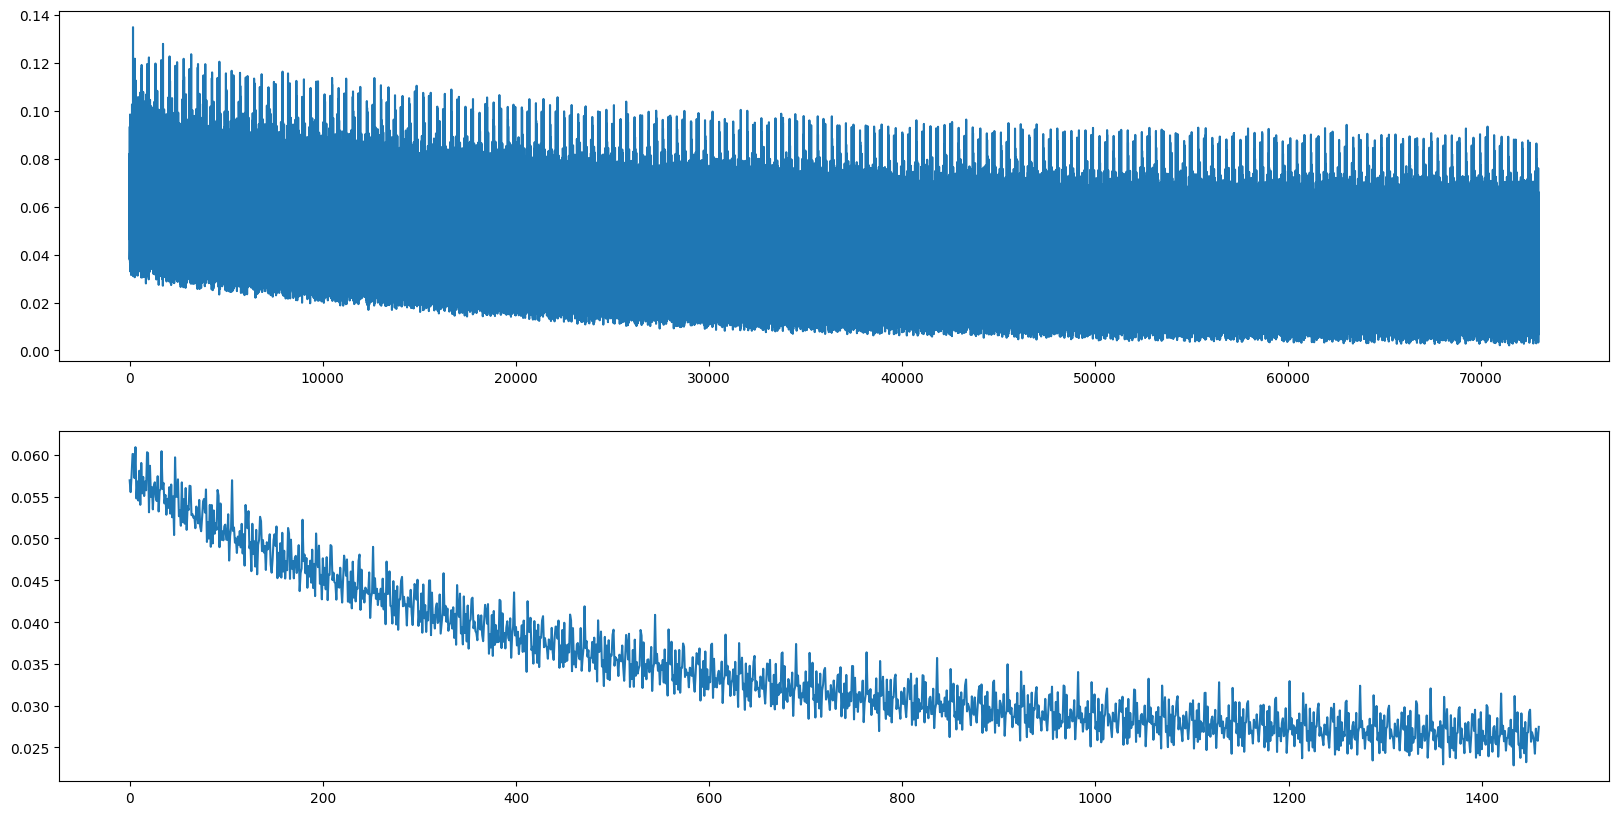

In [32]:
fig, ax = plt.subplots(2,1,figsize=(20, 10))
losses = np.array(losses)
ax[0].plot(losses)
ax[1].plot(losses.reshape(-1, 50).mean(axis=1))

IndexError: index 3 is out of bounds for axis 0 with size 3

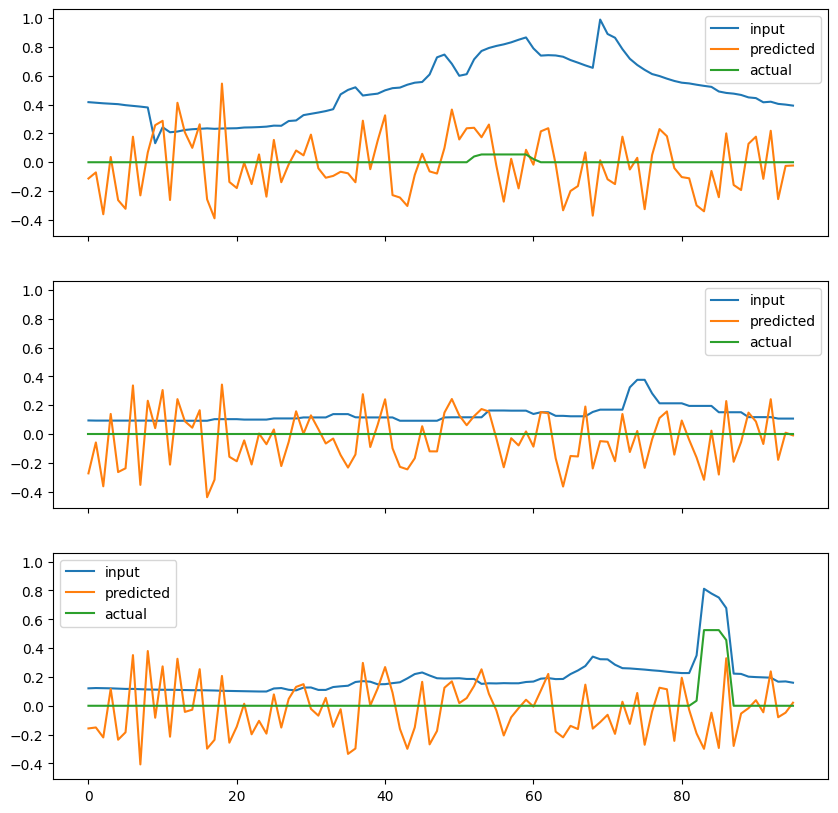

In [6]:
with torch.no_grad():
    # np.random.seed(42)
    fig, ax = plt.subplots(3,1, figsize=(10, 10), sharex=True, sharey=True)

    for i in range(5):
        
        random_idx = np.random.randint(0, len(train_dataset))
        x, y = train_dataset[random_idx]
            

        preds = model(x).detach().numpy()
        y = y.detach().numpy()
        delta = np.abs(preds - y)
        
        ax[i].plot(x, label='input')
        ax[i].plot(preds, label='predicted')
        ax[i].plot(y, label='actual')
        ax[i].legend()
        
    plt.show()

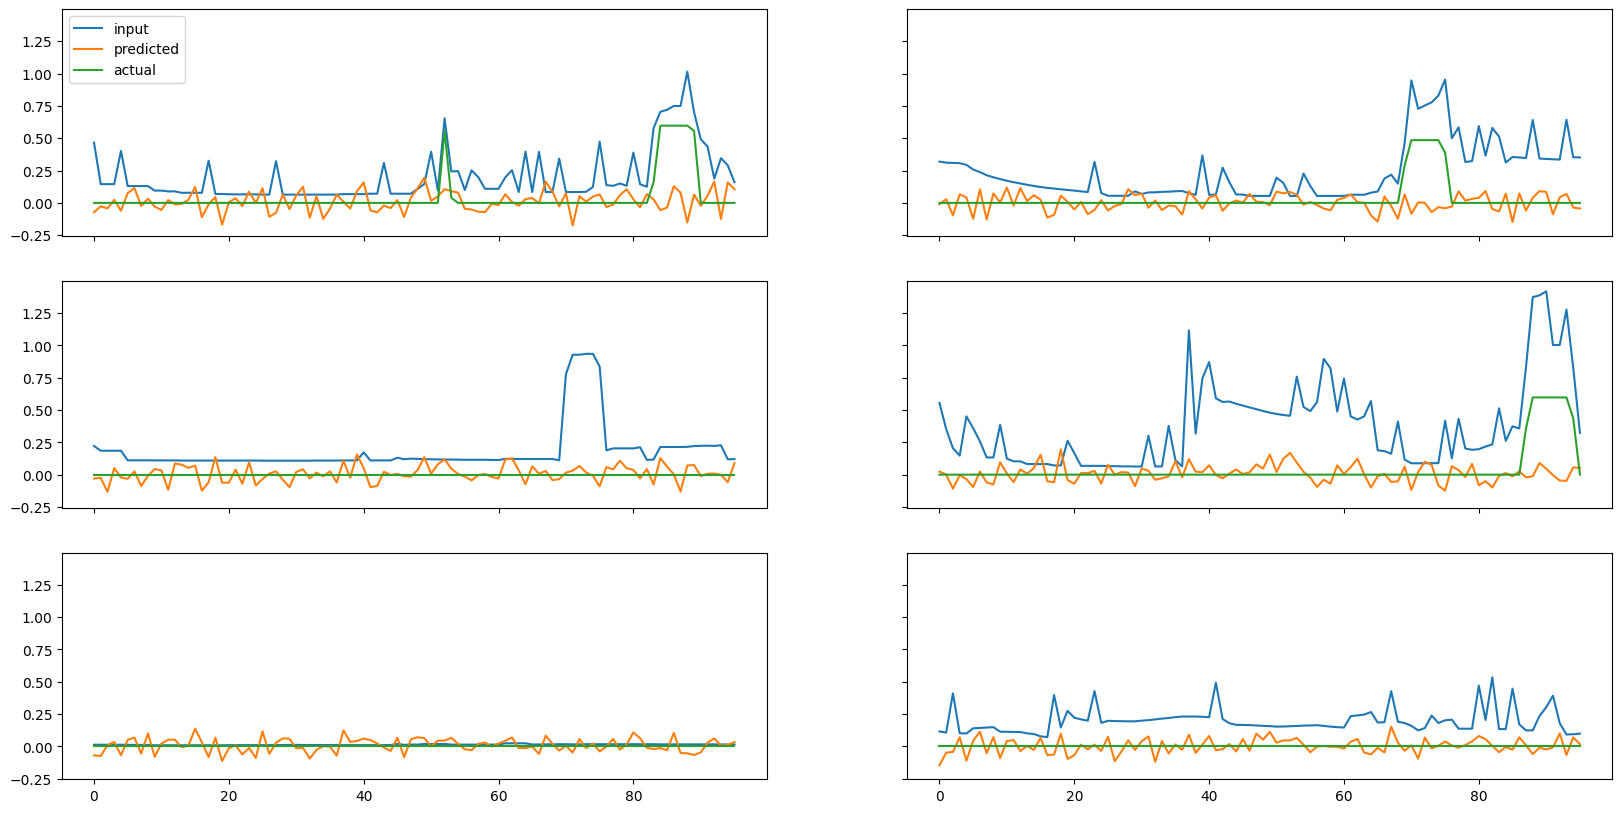

In [31]:
with torch.no_grad():
    # np.random.seed(42)
    fig, ax = plt.subplots(3,2, figsize=(20, 10), sharex=True, sharey=True)

    for i in range(3):
        for j in range(2):
            random_idx = np.random.randint(0, len(train_dataset))
            x, y = train_dataset[random_idx]
                

            preds = model(x).detach().numpy()
            y = y.detach().numpy()
            delta = np.abs(preds - y)
            
            ax[i][j].plot(x, label='input')
            ax[i][j].plot(preds, label='predicted')
            ax[i][j].plot(y, label='actual')
            if i == 0 and j == 0:
                ax[i][j].legend()
        
    plt.show()

In [270]:
for i, col in enumerate(train_dataset.col_names):
    if 'lighting' in col:
        print(i, col)
        break

877 y__lighting_exterior__00


(array([ 57077., 119013., 119337., 119791., 118519., 118426., 119857.,
        118885., 118905.,  46190.]),
 array([-0.03522618, -0.02810689, -0.0209876 , -0.0138683 , -0.00674901,
         0.00037028,  0.00748957,  0.01460886,  0.02172815,  0.02884745,
         0.03596674]),
 <BarContainer object of 10 artists>)

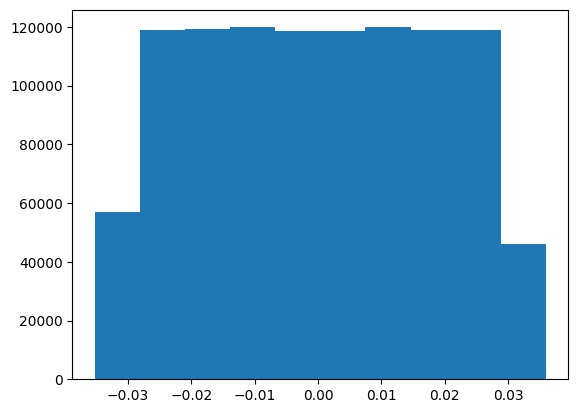

In [213]:
plt.hist(model.fc2.weight.detach().numpy().flatten())

In [184]:
# eval
with torch.no_grad():
    total_loss = 0
    for i, (t, h, x, T, y) in enumerate(val_dataloader):
        outputs = model(t, h, x, T)
        loss = criterion(outputs, y)
        total_loss += loss.item()
    print(f'Validation loss: {total_loss / len(val_dataloader)}')

    total_loss = 0
    for i, (t, h, x, T, y) in enumerate(train_dataloader):
        outputs = model(t, h, x, T)
        loss = criterion(outputs, y)
        total_loss += loss.item()
    print(f'Training loss: {total_loss / len(train_dataloader)}')

Validation loss: 0.021852240711450577
Training loss: 0.016896234769374133


In [332]:
dataset = resdata__allsignals(BASEDIR, TRAINING_FILES)

with torch.no_grad():
    for t, h, x, T, y in dataset:
        assert x.allclose(y.sum(axis=0))
        


In [327]:
y.sum(axis=0).shape

torch.Size([96])

In [328]:
x.shape

torch.Size([96])